# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression and energy budget - AMET (ERAI) & OMET (ORAS4) ** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.08.15 ** <br>
** Last Update  : 2018.09.18 ** <br>
Description  : This script serves to investigate the compensation between energy transport in the atmosphere and ocean. It works with AMET and OMET estimated from ERA-Interim and ORAS4. Lead/lag regressions are performed to check the compensation.<br>
Return Values : jpeg <br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

Initialization - Start with location of input and extraction of variables
Time span of each product:
- **ERA-Interim** 1979 - 2016
- **MERRA2**      1980 - 2016
- **JRA55**       1979 - 2015
- **ORAS4**       1958 - 2017
- **GLORYS2V3**   1993 - 2014
- **SODA3**       1980 - 2015

In [5]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/yang/workbench/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    output_path = '/home/yang/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_leadlag/stat_erai_oras_layer/leadlag/amet_FD_omet'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_SIC_SST_SLP = Dataset(os.path.join(datapath_ERAI_fields,
                                              'surface_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_AMET = Dataset(os.path.join(datapath,
                                             'era_model_subdaily_1979_2016_amet.nc'))
    dataset_ORAS4_OMET = Dataset(os.path.join(datapath,
                                              'oras_model_monthly_1958_2017_omet.nc'))
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath,
                                              'oras_model_monthly_1958_2017_ohc.nc'))
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                                    'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 3D fields [year, month, lat]
    # since OMET is from 20N - 90N, AMET is from 90N to 20N, we have to reverse it
    # for interpolation, x should be monotonically increasing
    AMET_0_ERAI = dataset_ERAI_AMET.variables['E_total_int'][:,:,::-1]/1000 # from Tera Watt to Peta Watt
    # 3D fields [year, month, lat]
    OMET_int_ORAS4 = dataset_ORAS4_OMET.variables['E_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OMET_atl_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_int'][21:-1,:,180:]/1000
    OMET_atl_100_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_100_int'][21:-1,:,180:]/1000
    OMET_atl_300_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_300_int'][21:-1,:,180:]/1000
    OMET_atl_700_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_700_int'][21:-1,:,180:]/1000
    OMET_atl_2000_int_ORAS4 = dataset_ORAS4_OMET.variables['E_atl_2000_int'][21:-1,:,180:]/1000
    
    OMET_pac_int_ORAS4 = dataset_ORAS4_OMET.variables['E_pac_int'][21:-1,:,180:]/1000
    # 3D fields [year, month, lat]
    OHC_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_int'][21:-1,:,180:]/1000 # from Tera Watt to Peta Watt # start from 1979
    OHC_atl_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_int'][21:-1,:,180:]/1000
    OHC_atl_100_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_100_int'][21:-1,:,180:]/1000
    OHC_atl_300_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_300_int'][21:-1,:,180:]/1000
    OHC_atl_700_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_700_int'][21:-1,:,180:]/1000
    OHC_atl_2000_int_ORAS4 = dataset_ORAS4_OHC.variables['OHC_atl_2000_int'][21:-1,:,180:]/1000   
    # other dimensions
    year_ORAS4 = dataset_ORAS4_OMET.variables['year'][21:-1]    # from 1979 to 2016
    year_ERAI = dataset_ERAI_AMET.variables['year']
    latitude_OMET_ORAS4 = dataset_ORAS4_OMET.variables['latitude_aux'][180:]
    latitude_AMET_ERAI = dataset_ERAI_AMET.variables['latitude'][::-1]  

*********************** extract variables *************************


In [ ]:
    # check the latitude
    #print (latitude_AMET_ERAI[:71])

Perform interpolation as AMET and OMET has different resoltion in terms of the latitudes.

In [3]:
    print ('*******************  interpolation for regression   **********************')
    # interpolate OMET on the latitude of AMET
    # ORAS4 - ERAI
    # glole
    OMET_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    # atlantic
    OMET_atl_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    # an easy check for the interpolation
    #plt.plot(latitude_AMET_ERAI,OMET_atl_ORAS4_interp_ERAI[2,11,:],linewidth=6.0)
    #plt.plot(latitude_OMET_ORAS4,OMET_atl_int_ORAS4[2,11,:])
    OMET_atl_100_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_100_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OMET_atl_300_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_300_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OMET_atl_700_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_700_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OMET_atl_2000_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_atl_2000_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    #pacific
    OMET_pac_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OMET_pac_int_ORAS4, 
                                 latitude_OMET_ORAS4, latitude_AMET_ERAI)
    
    # interpolate OHC on the latitude of AMET
    # atlantic
    OHC_atl_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OHC_atl_int_ORAS4, 
                                latitude_OMET_ORAS4, latitude_AMET_ERAI)
    # an easy check for the interpolation
    #plt.plot(latitude_AMET_ERAI,OHC_atl_ORAS4_interp_ERAI[2,11,:],linewidth=6.0)
    #plt.plot(latitude_OMET_ORAS4,OHC_atl_int_ORAS4[2,11,:])
    OHC_atl_100_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OHC_atl_100_int_ORAS4, 
                                    latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OHC_atl_300_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OHC_atl_300_int_ORAS4, 
                                    latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OHC_atl_700_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OHC_atl_700_int_ORAS4, 
                                    latitude_OMET_ORAS4, latitude_AMET_ERAI)
    OHC_atl_2000_ORAS4_interp_ERAI = meta.statistics.operator.interpolation(OHC_atl_2000_int_ORAS4, 
                                     latitude_OMET_ORAS4, latitude_AMET_ERAI)

*******************  interpolation for regression   **********************


*******************  postprocess with statistical tool  *********************
***********!@#$%^&*  Lead/ Lag regression of ORAS4 - ERAI  !@#$%^&***********
======================   AMET + 0 & OMET + atl + 0   ========================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on another.
One time series is regressed on another.
This a regression with lead/lag analysis.


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Create contour plot of correlation coefficient.


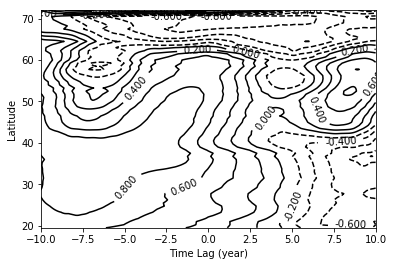

In [6]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&*  Lead/ Lag regression of ORAS4 - ERAI  !@#$%^&***********')
    print ('======================   AMET + 0 & OMET + atl + 0   ========================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=180, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=180, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_AMET_ERAI[:71], r[:,:71], lag,
                                         os.path.join(output_path,
                                         'leadlag_ERAI_0_ORAS4_atl_0_omet_interdecadal.png'))

======================   AMET + 0 & OMET + pac + 0   ========================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on another.
One time series is regressed on another.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Create contour plot of correlation coefficient.


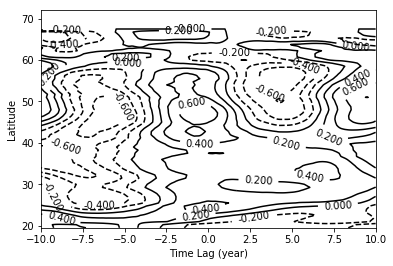

In [5]:
    print ('======================   AMET + 0 & OMET + pac + 0   ========================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=60, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_pac_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=60, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_AMET_ERAI[:71], r[:,:71], lag,
                                         os.path.join(output_path,
                                         'leadlag_ERAI_0_ORAS4_pac_0_omet_interannual.png'))

======================   AMET + 0 & OMET + glo + 0   ========================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on another.
One time series is regressed on another.
This a regression with lead/lag analysis.


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Create contour plot of correlation coefficient.


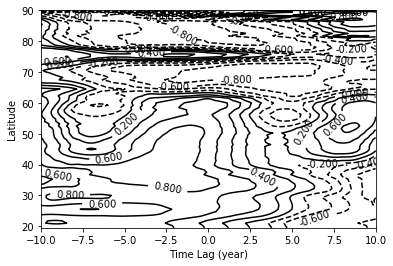

In [7]:
    print ('======================   AMET + 0 & OMET + glo + 0   ========================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=180, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=180, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_AMET_ERAI[:], r[:,:], lag,
                                         os.path.join(output_path,
                                         'leadlag_ERAI_0_ORAS4_globe_0_omet_interdecadal.png'))

====================   AMET + 0 & OMET + atl + 100   ======================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on another.
One time series is regressed on another.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Create contour plot of correlation coefficient.


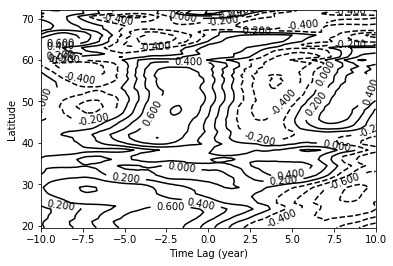

In [11]:
    print ('====================   AMET + 0 & OMET + atl + 100   ======================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=60, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_100_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=60, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_AMET_ERAI[:71], r[:,:71], lag,
                                         os.path.join(output_path,
                                         'leadlag_ERAI_0_ORAS4_atl_100_omet_interannual.png'))

====================   AMET + 0 & OMET + atl + 300   ======================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on another.
One time series is regressed on another.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Create contour plot of correlation coefficient.


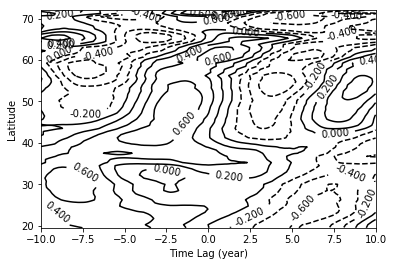

In [10]:
    print ('====================   AMET + 0 & OMET + atl + 300   ======================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=60, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_300_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=60, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_AMET_ERAI[:71], r[:,:71], lag,
                                         os.path.join(output_path,
                                         'leadlag_ERAI_0_ORAS4_atl_300_omet_interannual.png'))

====================   AMET + 0 & OMET + atl + 700   ======================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on another.
One time series is regressed on another.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Create contour plot of correlation coefficient.


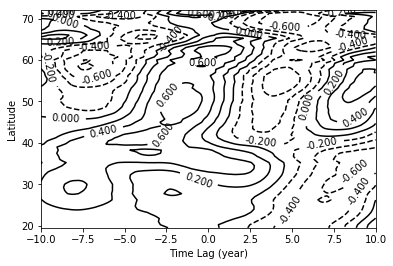

In [13]:
    print ('====================   AMET + 0 & OMET + atl + 700   ======================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=60, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_700_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=60, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_AMET_ERAI[:71], r[:,:71], lag,
                                         os.path.join(output_path,
                                         'leadlag_ERAI_0_ORAS4_atl_700_omet_interannual.png'))

====================   AMET + 0 & OMET + atl + 2000   ======================
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data has the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on another.
One time series is regressed on another.
This a regression with lead/lag analysis.
Positive lag means 2nd input leads 1st


/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/yang/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:118: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


Create contour plot of correlation coefficient.


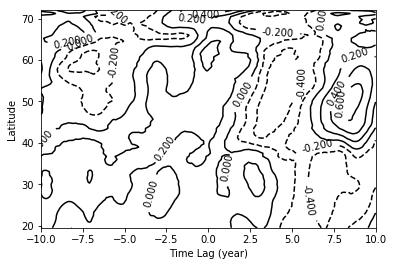

In [14]:
    print ('====================   AMET + 0 & OMET + atl + 2000   ======================')
    stat_AMET_ERAI = meta.statistics.operator(AMET_0_ERAI)
    stat_AMET_ERAI.anomaly()
    stat_AMET_ERAI.detrend()
    # by default, the running mean is taken with a window of 60 months
    stat_AMET_ERAI.lowpass(window=12, obj='detrend')
    stat_OMET_ORAS4 = meta.statistics.operator(OMET_atl_2000_ORAS4_interp_ERAI)
    stat_OMET_ORAS4.anomaly()
    stat_OMET_ORAS4.detrend()
    stat_OMET_ORAS4.lowpass(window=12, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass)
    #meta.visualizer.plots.linearRegress(latitude_AMET_ERAI, r,
    #                                    os.path.join(output_path,'regress_ERAI_0_ORAS4_atl_0.png'))
    # set the lead lag
    lag = 120
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_OMET_ORAS4._lowpass, lag)
    # r[lag,lat]
    meta.visualizer.plots.leadlagRegress(latitude_AMET_ERAI[:71], r[:,:71], lag,
                                         os.path.join(output_path,
                                         'leadlag_ERAI_0_ORAS4_atl_2000_omet_anuual.png'))